## Modeling scATAC-seq data with mubind (PBMC, 10x)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
working_dir = os.path.expanduser('~/workspace/theislab/mubind/docs/notebooks/scatac')
if os.path.exists(working_dir):
    os.chdir(working_dir)

In [3]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../../../../../annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [4]:
import scanpy as sc

In [5]:
# create a backup with neighbors+umap included
atac_datadir = '../../../../atac_poisson_study/data'
adata_updated_path = os.path.join(atac_datadir, '10k_pbmc_ATACv2_nextgem_Chromium_Controller_filtered_peak_bc_matrix_with_umap.h5ad')
if not os.path.exists(adata_updated_path):
    adata = mb.bindome.datasets.scATAC.PBMCs_10x_v2(datadir=atac_datadir)
    peak_ids = adata.var_names
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    adata.write(adata_updated_path, compression='lzf')
adata = sc.read_h5ad(adata_updated_path)


In [6]:
adata.layers['counts'] = adata.X

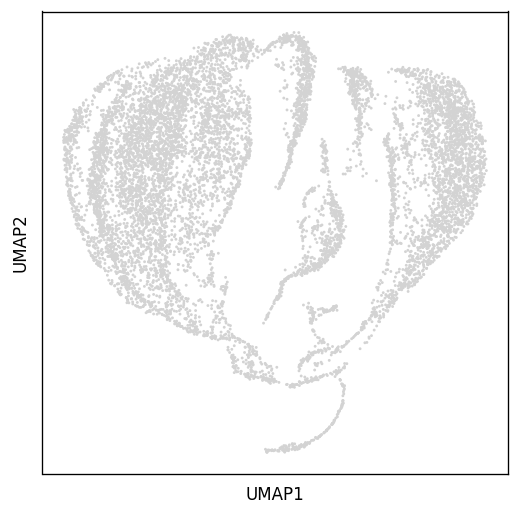

In [7]:
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 120})
sc.pl.umap(adata)

In [8]:
adata= adata[:,adata.var.chr == 'chr11'].copy()

In [9]:
ad = mb.pp.sample_anndata(adata, n_sample_obs=500, n_sample_var=500) # adata.shape[0], n_sample_var=adata.shape[1])
ad.shape

(500, 500)

### This extension is needed to make peaks homogeneous, and avoid long peaks

In [10]:
extend = 50
ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
ad.var['summit.start'] = ad.var['summit'] - extend
ad.var['summit.end'] = ad.var['summit'] + extend
ad.var['k.summit'] = ad.var['chr'].astype(str) + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)


### Get sequences from fasta files

In [11]:
ad

AnnData object with n_obs × n_vars = 500 × 500
    var: 'gene_ids', 'feature_types', 'genome', 'chr', 'start', 'end', 'peak.length', 'summit', 'summit.start', 'summit.end', 'k.summit'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [12]:
# focus on a specific chromsome
gen_path = os.path.join(bd.constants.ANNOTATIONS_DIRECTORY, 'hg38/genome/chr11.fa')
os.path.exists(gen_path)

True

In [13]:
len(ad.var_names)

500

In [14]:
hs_fastas = bd.tl.get_fastas(gen_path)
print('here...')

AttributeError: module 'bindome.tl' has no attribute 'get_fastas'

In [ ]:
use_bedtools = False
if not use_bedtools:
    seqs = []
    for ri, r in ad.var.iterrows():
        i, j = r['start'], r['end']
        s = hs_fastas[0][1][i: j].upper()
        seqs.append(s)
else:
    n_seqs = min(len(ad.var_names), 2)# adata.shape[1] # None # 1000
    print(n_seqs)
    seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='hg38', uppercase=True,
                                                overwrite=True, log=True, gen_path=gen_path)

    keys = set([s[0] for s in seqs])
    ad = ad[:,ad.var['k.summit'].isin(keys)]
    # seqs = [[s[0], s[1].upper()] for s in seqs[0]]

2
convert bed to fasta
/tmp/tmp19p_w9i7
genome hg38 False
../../../../../../annotations/hg38/genome/chr11.fa
True ../../../../../../annotations/hg38/genome/chr11.fa
running bedtools...
bedtools getfasta -fi ../../../../../../annotations/hg38/genome/chr11.fa -bed /tmp/tmp19p_w9i7 -fo /tmp/tmpaiw7_5xs
get fasta
/tmp/tmpaiw7_5xs


### Preparation of training data

In [ ]:
ad.shape

(500, 2)

In [ ]:
print('here..')

here..


In [ ]:
# use the raw counts across cells
next_data = pd.DataFrame(ad.X.T.A) # sparse.from_spmatrix(counts.A)
next_data['var'] = next_data.var(axis=1)
next_data.index = seqs
next_data.index.name = 'seq'
print(next_data.shape)

(2, 501)


In [ ]:
next_data

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,var
seq,,,,,,,,,,,,,,,,,,,,,
ACGGCTGAGGAAGGGCCCGTCCCGCCTTCCCCGGCGCGCCATGGAGCCCCGGGCGGTTGCAGAAGCCGTGGAGACGGGTGAGGAGGATGTGATTATGGAA,0.0,0.0,1.0,2.0,0.0,0.0,3.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.540778
CTGTGGGCTCCTGTGGTGGACACTCCCCTCAGCCTCCTCGGCTGCCCTCCCTGATCCCAGAATGTCTGTGGTGAGTGGTCCTGTTTAGGGCTCAAGGTCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046798


In [ ]:


# selection of cells based on overall var score
n_cells = 1000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)
next_data_sel
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']
df = next_data_sel.copy() # sample
print(next_data_sel.shape)


(2, 500)


In [ ]:
# enr series = False indicates that everything is independent.
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)

In [ ]:
# df = next_data_sel.copy()
# dataset = mb.datasets.GenomicsDataset(df)
# train = tdata.DataLoader(dataset=dataset, batch_size=1000, shuffle=True)

train = tdata.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)

In [ ]:
device

device(type='cpu')

In [ ]:
criterion = mb.tl.PoissonLoss()
n_kernels = 2
w = [20 for r in range(n_kernels)]
model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2] + w,
                                       # use_dinuc=True, dinuc_mode='full',
                                       optimize_sym_weight=False,
                                       optimize_exp_barrier=True,
                                       optimize_log_dynamic=False,
                                       use_dinuc=False,
                                       device=device,
                                       dinuc_mode=None) # .cuda()


### Include kNN into the model

In [ ]:
model.prepare_knn(ad)

/root/miniconda3/envs/mubind/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


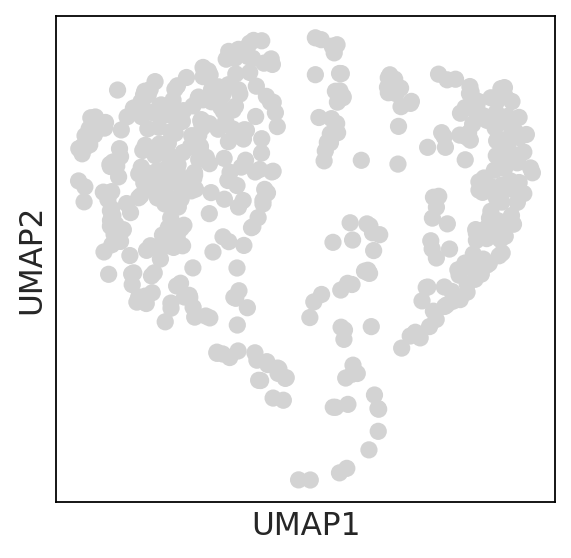

In [ ]:
sc.pl.umap(ad)

In [ ]:
model.prepare_knn(ad)

/mnt/c/Users/ibarr/Dropbox/workspace/theislab/mubind/mubind/models/models.py:248: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata[:, ~zero_counts].uns['neighbors']['connectivities'].A).to_sparse().requires_grad_(True) # .cuda()


In [ ]:
# model = model.cuda()

In [ ]:
import torch.optim as topti


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
model

Multibind(
  (padding): ConstantPad2d(padding=(19, 19, 0, 0), value=0.25)
  (binding_modes): BindingModesSimple(
    (conv_mono): ModuleList(
      (0): None
      (1): Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
      (2): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
      (3): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
    )
    (conv_di): ModuleList(
      (0): None
    )
  )
  (activities): ActivitiesLayer(
    (log_activities): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1x500]
        (1): Parameter containing: [torch.float32 of size 1x500]
        (2): Parameter containing: [torch.float32 of size 1x500]
        (3): Parameter containing: [torch.float32 of size 1x500]
    )
  )
  (selex_module): SelexModule()
  (criterion): PoissonLoss()
)

In [ ]:
model, best_loss = model.optimize_iterative(train, n_epochs=[500, 200, 200, 200], show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                            opt_kernel_shift=[0, 0, 1, 1],
                                            opt_kernel_length=[0, 0, 1, 1],
                                            shift_max=1, shift_step=1, optimiser=topti.Adam,
                                            # skip_kernels=range(2, 4),
                                            n_batches=1, n_rounds=df.shape[1], num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                            kernels = [0] + [2] + [20, 20], r2_per_epoch=True,
                                            early_stopping=50, log_each=10, w=25, max_w=25) #  target_dim=train.dataset.signal.shape[1])

In [ ]:
r2 = mb.tl.scores(model, train, by='batch')
print("R^2:", r2)


R^2: {0: {'r2_counts': 0.8822376138695656, 'r2_foldchange': 0.0, 'r2_enr': 0.0, 'r2_fc': nan, 'pearson_foldchange': nan}}


True
2


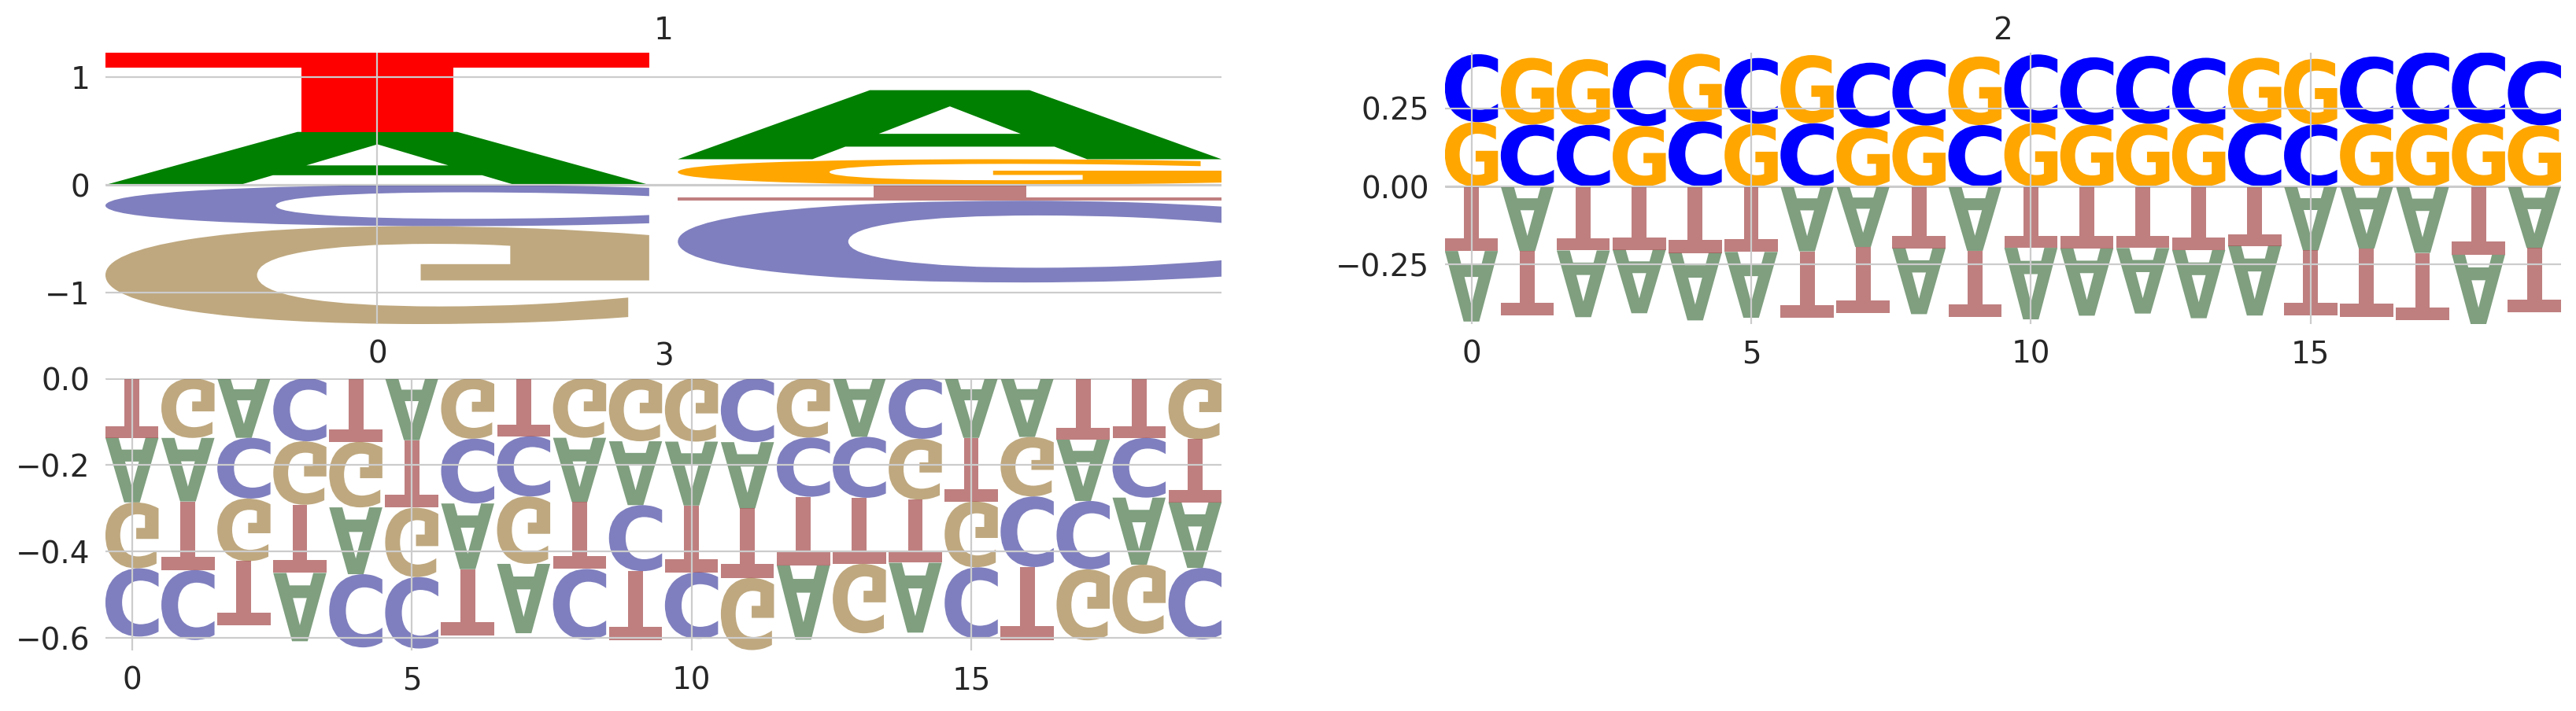

In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
mb.pl.conv(model, n_cols=2, show=True)
plt.show()


### Here we attempt to visualize the log_dynamic scores

<AxesSubplot: xlabel='index', ylabel='r2'>

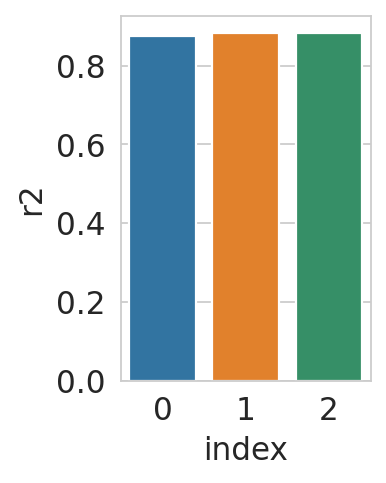

In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
sns.barplot(data=r2, x='index', y='r2')

In [ ]:
# dyn_score
dyn_score = mb.tl.dynamic_score(model)
dyn_score_scaled = (dyn_score - dyn_score.min()) / (dyn_score.max() - dyn_score.min())
ad.obs['dynamic_score'] = dyn_score_scaled

Text(0.5, 12.355555555555531, 'dynamic score (normalized)')

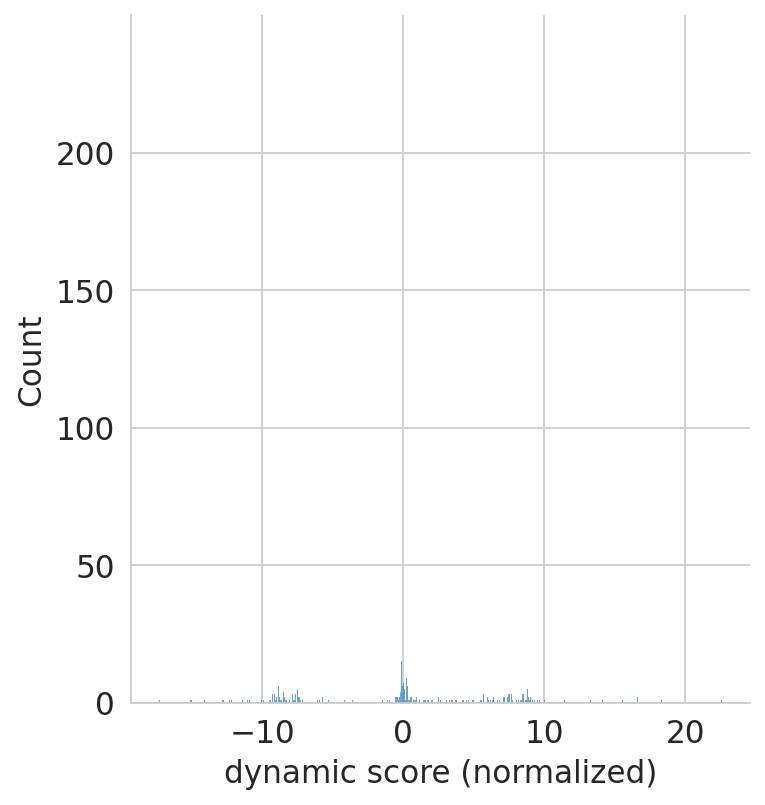

In [ ]:
ad.obs['dynamic_score_cluster'] = np.where(dyn_score_scaled > dyn_score_scaled.mean(), 'dynamic', 'static')
mu, sigma = dyn_score.mean(), dyn_score.std()
zscore = ((dyn_score - mu) / sigma)
z1 = np.where(zscore > 1, 'dynamic', 'static')
z2 = np.where(zscore > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2

#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
sns.displot(dyn_score)
plt.xlabel('dynamic score (normalized)')


In [ ]:
sc.tl.umap(ad)

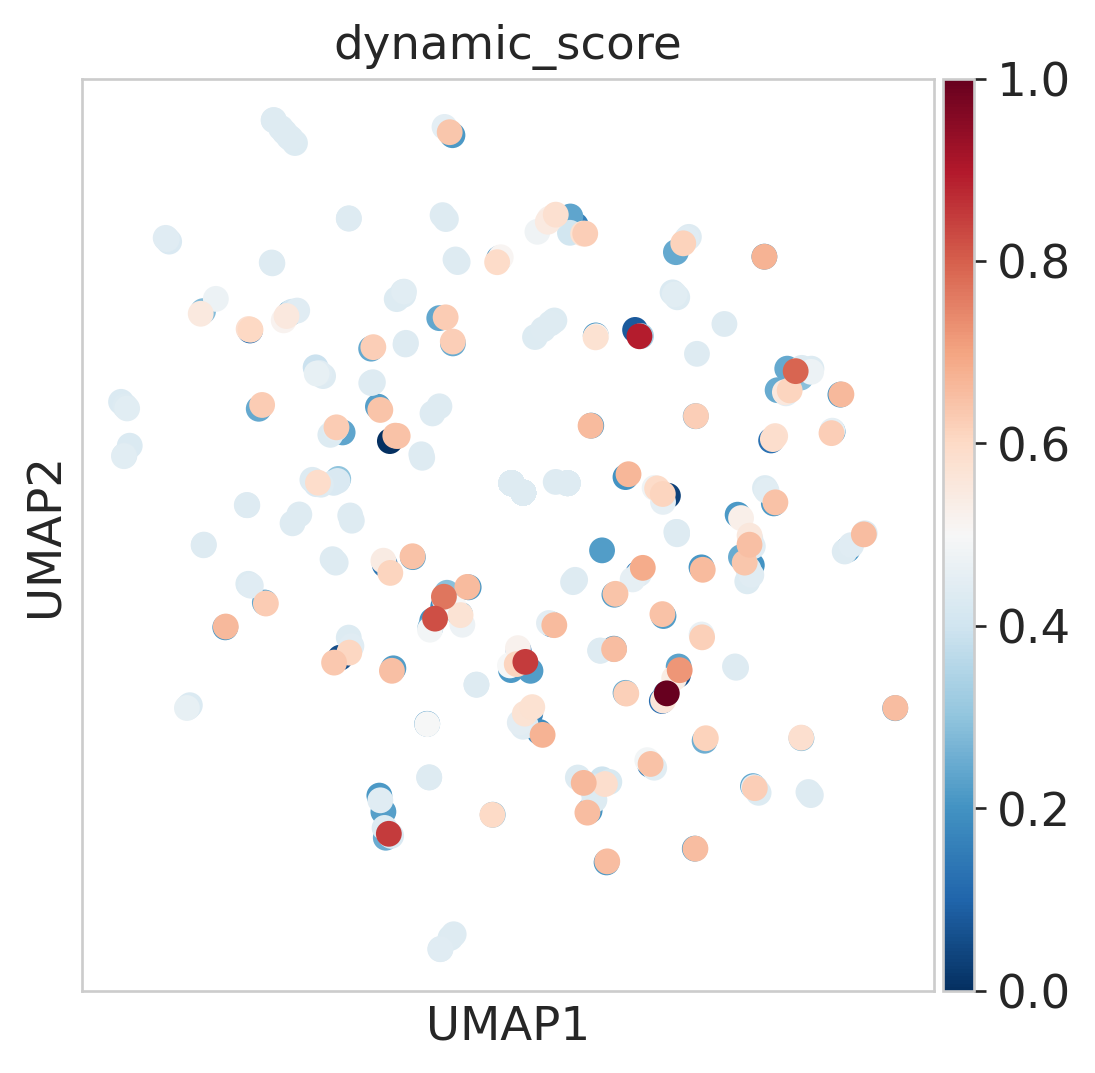

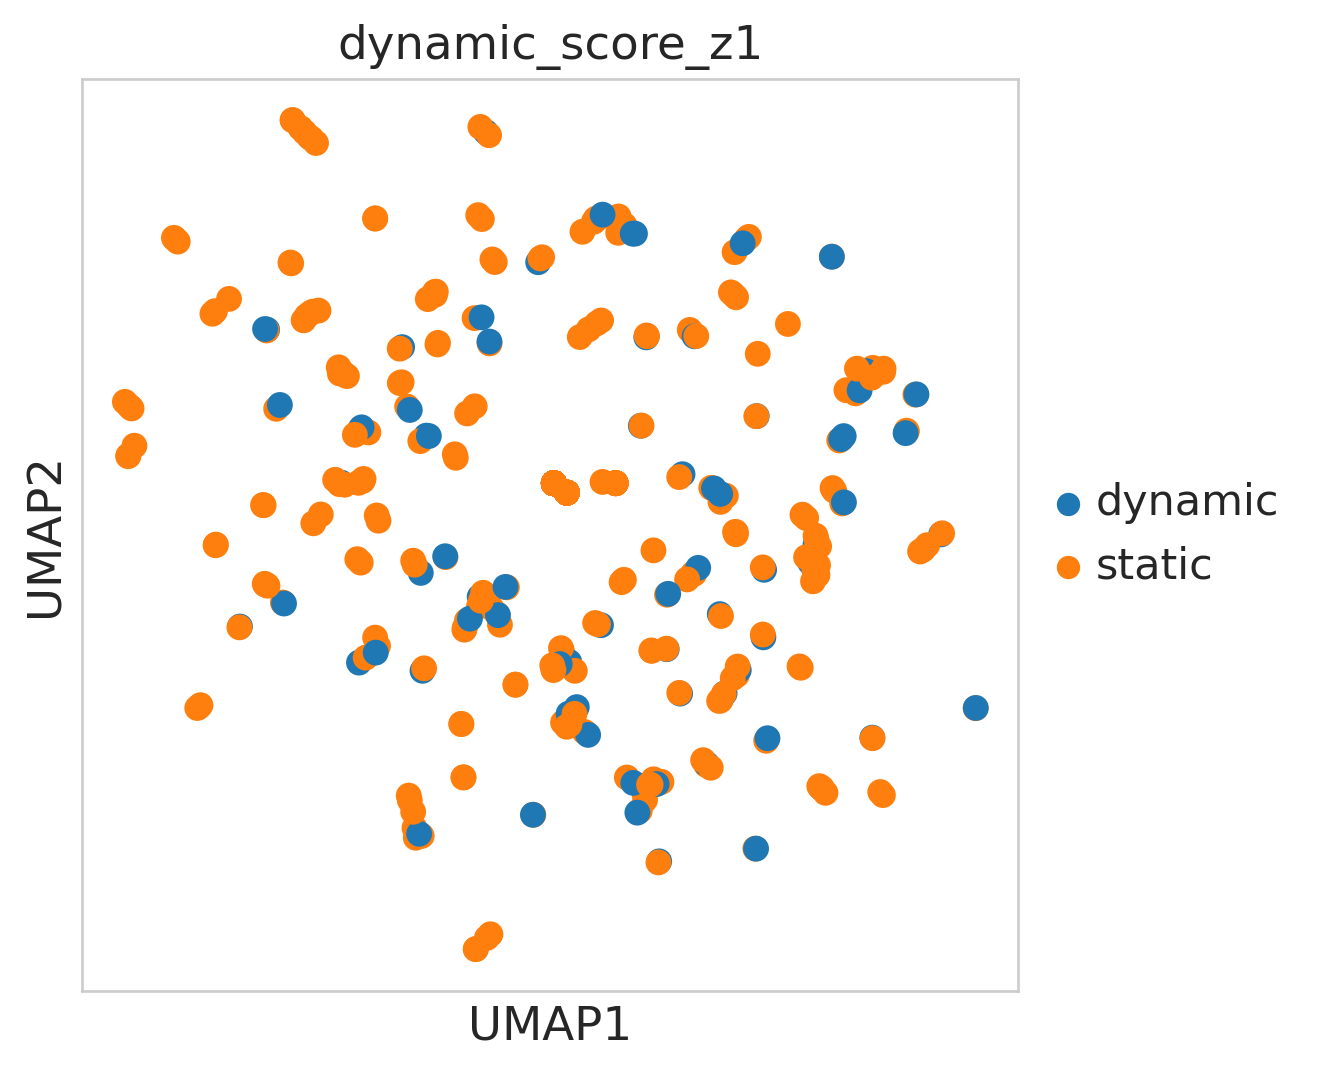

In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 120
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)


In [ ]:
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')

In [ ]:
sc.pl.embedding_density?

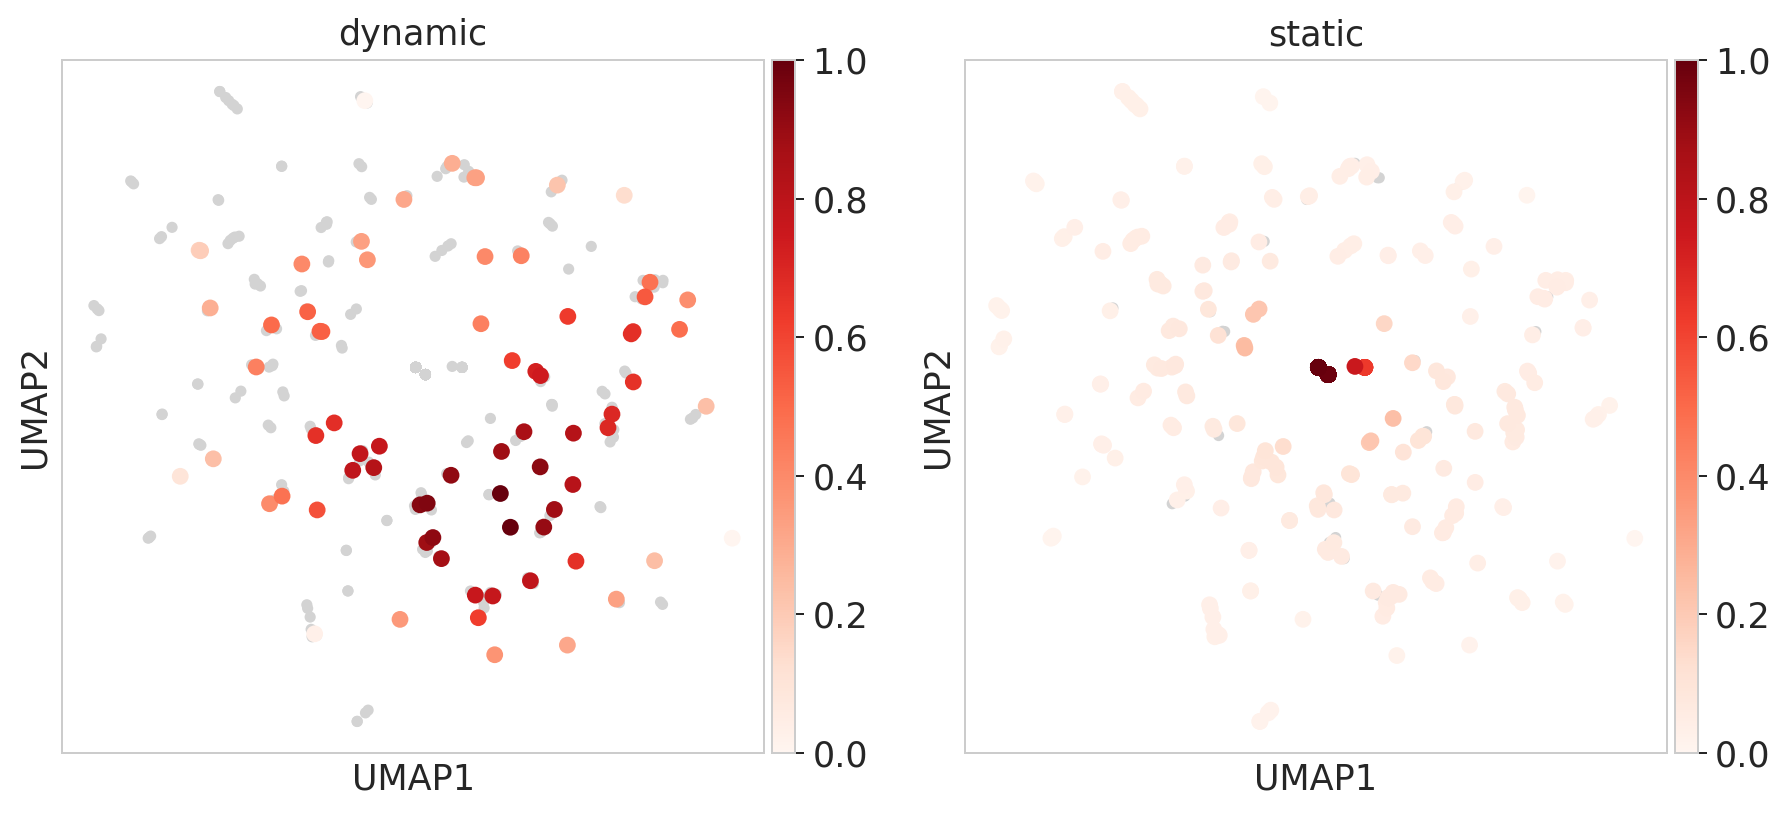

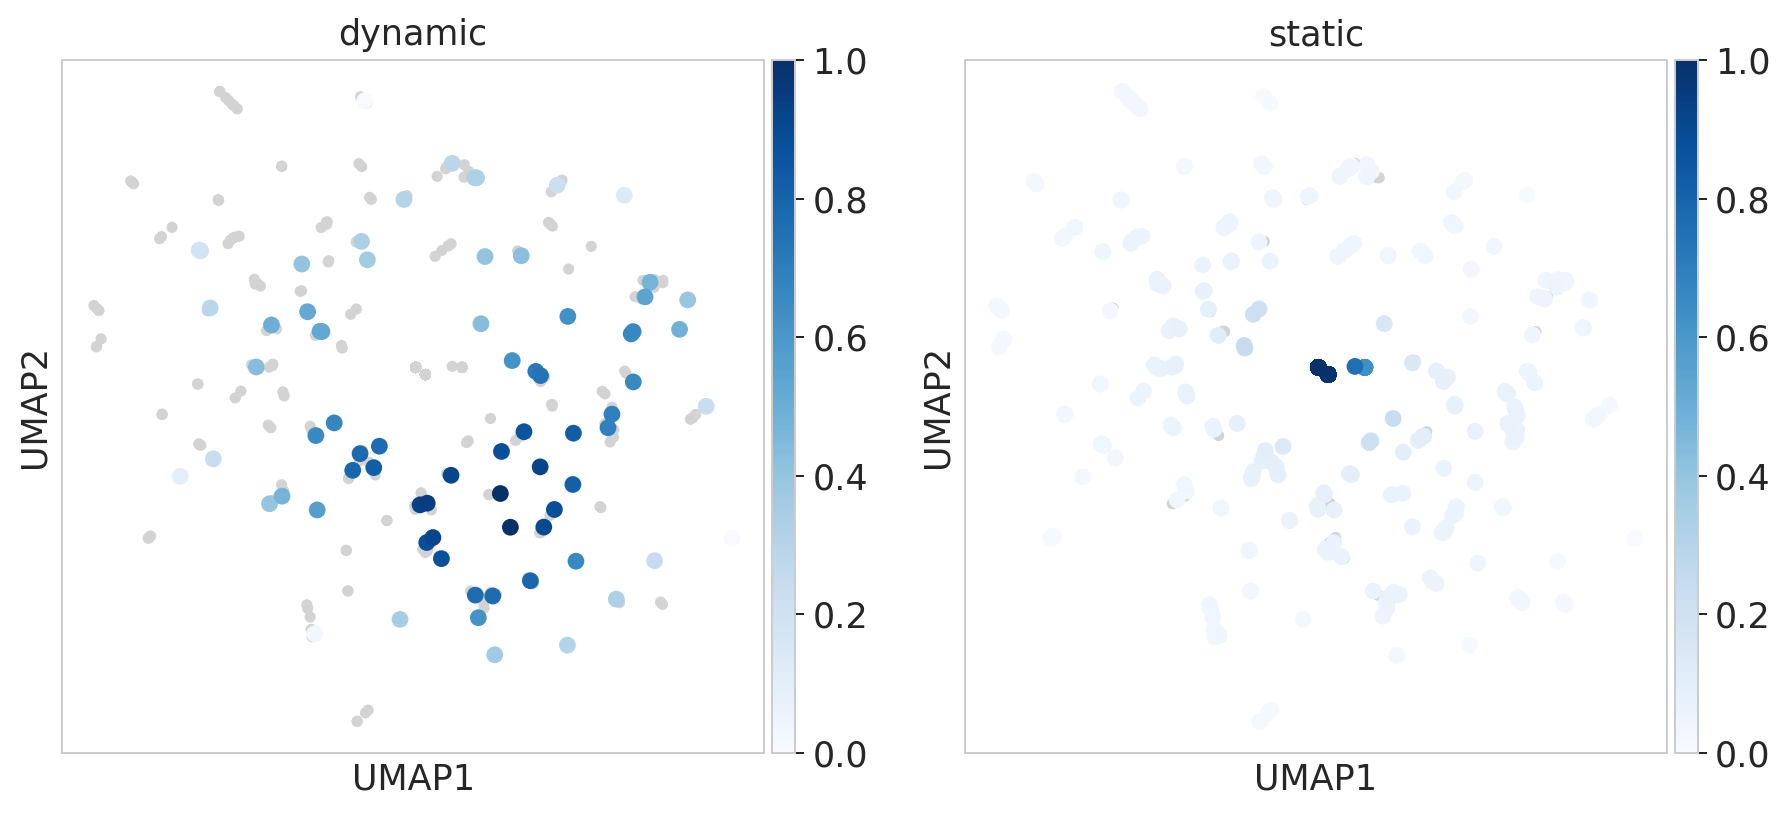

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group=['dynamic', 'static'], color_map='Reds') # basis='umap', groupby='dynamic_score_cluster')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group=['dynamic', 'static'], color_map='Blues') # basis='umap', groupby='dynamic_score_cluster')
# sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')

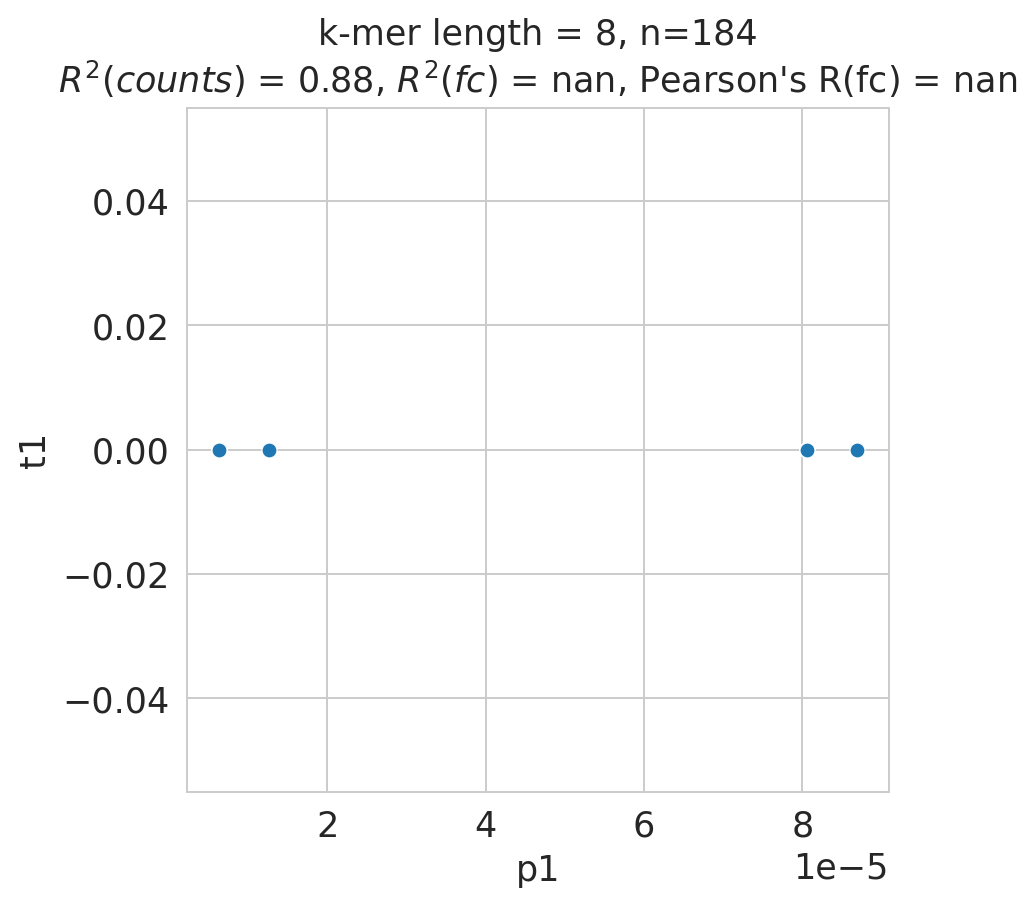

{'r2_counts': 0.8822376138695656,
 'r2_foldchange': 0.0,
 'r2_enr': 0.0,
 'r2_fc': nan,
 'pearson_foldchange': nan}

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)

True
12


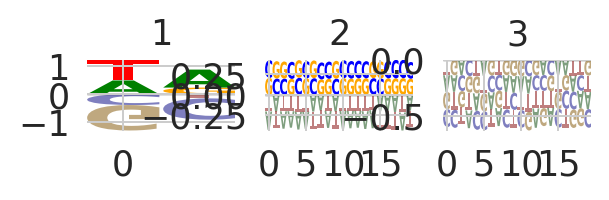

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
mb.pl.conv(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=5, n_cols=12) # n_cols=len(reduced_groups))


In [ ]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)


total GB used: 2.154908
